In [1]:
print("Bismillah")

Bismillah


# **Imports**

In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 142 µs (started: 2021-02-08 22:05:57 +00:00)


In [3]:
# necessary imports
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from google.colab.patches import cv2_imshow

time: 1.23 s (started: 2021-02-08 22:05:57 +00:00)


# Initializing

In [4]:
img_height = 200
img_width = 200
batch_size = 32
nb_epochs = batch_size
patience_val = 10
model_name = "VGGFace_15000_Onwards_1"
cutout_size = 20

time: 2.68 ms (started: 2021-02-08 22:05:58 +00:00)


# VGG FACE

In [5]:
!sudo pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-5cpgoy8z
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-5cpgoy8z
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=9422f28225937f479eb5b2338238fbe10254c10745ba24613b64e72444b91afb
  Stored in directory: /tmp/pip-ephem-wheel-cache-j3jm2w_f/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
time: 4.04 s (started: 2021-02-08 22:05:58 +00:00)


In [6]:
!pip install --upgrade keras_applications
from keras_vggface.vggface import VGGFace
from keras.models import Model
from keras.layers import Dense

model = VGGFace(model='senet50', include_top=False, input_shape=(img_width, img_height, 3), pooling='avg')

     |████████████████████████████████| 51kB 7.5MB/s 
104947712/104944616 [==============================] - 2s 0us/step
time: 12.9 s (started: 2021-02-08 22:06:02 +00:00)


In [7]:
class1 = Dense(1024, activation='relu')(model.layers[-1].output) # add FC layer on last layer
class2 = Dense(512, activation='relu')(class1) # add FC layer on previous layer
output = Dense(2)(class2) # add wx+b
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 100, 100, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 100, 100, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 100, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

# Compile the model

In [14]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics='MeanSquaredError')

time: 22.2 ms (started: 2021-02-08 22:25:52 +00:00)


# On the Fly Data Load

In [12]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
Trainingdf = pd.read_csv("/content/drive/MyDrive/CV/cv project/CV-Project/Aff-Wild/Training.csv")

time: 1.92 ms (started: 2021-02-08 15:46:05 +00:00)


In [50]:
training = Trainingdf.iloc[30000:45000]

time: 1.66 ms (started: 2021-02-08 10:41:01 +00:00)


In [ ]:
# from sklearn.utils import shuffle
# training = shuffle(training)

time: 86.7 ms (started: 2021-02-06 21:04:18 +00:00)


Loading Training Images

In [51]:
train_datagen = ImageDataGenerator(
    rescale=1./255
    ,validation_split=0.2) # set validation split

time: 1.68 ms (started: 2021-02-08 10:41:33 +00:00)


In [52]:
train_generator = train_datagen.flow_from_dataframe(
    training,
    directory=None,
    x_col="Image_Path",
    y_col=["Valence","Arousal"],
    target_size=(img_width, img_height),
    color_mode="rgb",
    class_mode="raw",
    batch_size=batch_size,
    shuffle=True,
    seed=11,
    subset="training"
    # interpolation="nearest",
)

Found 12000 validated image filenames.
time: 55min 18s (started: 2021-02-08 10:41:38 +00:00)


Loading Validation images

In [53]:
validation_generator = train_datagen.flow_from_dataframe(
    training,
    directory=None,
    x_col="Image_Path",
    y_col=["Valence","Arousal"],
    target_size=(img_width, img_height),
    color_mode="rgb",
    class_mode="raw",
    batch_size=batch_size,
    shuffle=True,
    seed=11,
    subset="validation"
    # interpolation="nearest",
)

Found 3000 validated image filenames.
time: 7.61 s (started: 2021-02-08 11:36:57 +00:00)


# **Save Path for the outputs**

In [8]:
save_path = '/content/drive/MyDrive/CV/cv project/CV-Project/Aff-Wild/TransferLearningOutputs/'+model_name

time: 1.3 ms (started: 2021-02-08 22:21:40 +00:00)


# Train the model

In [55]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

time: 1.66 ms (started: 2021-02-08 11:37:05 +00:00)


In [56]:
# patient early stopping 
es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=1, patience=patience_val)
mc = ModelCheckpoint(save_path+'/best_model.h5', monitor='val_mean_squared_error', mode='min', verbose=1, save_best_only=True)

time: 3.38 ms (started: 2021-02-08 11:37:05 +00:00)


In [ ]:
H = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs
    , callbacks= [es , mc]
    )

# Saving Model Weights and History

Saving Model weights

In [ ]:
# save the model's trained weights
model.save_weights(save_path+"/_transferOnwards_trained_wts.h5")

In [15]:
model.load_weights(save_path+'/best_model.h5')

time: 3.41 s (started: 2021-02-08 22:26:01 +00:00)


Saving History

In [67]:
import pickle
with open(save_path+'/historyOnwards', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

time: 10.4 ms (started: 2021-02-08 03:51:56 +00:00)


Loading history

In [18]:
import pickle
dbfile = open(save_path+'/historyOnwards', 'rb')      
db = pickle.load(dbfile) 
for keys in db: 
    print(keys, '=>', db[keys]) 
dbfile.close()

loss => [0.04679543152451515, 0.024569135159254074, 0.015386582352221012, 0.010194397531449795, 0.007684153970330954, 0.006026922259479761, 0.00520642613992095, 0.004637696780264378, 0.004313797224313021, 0.004400851204991341, 0.004419731441885233, 0.004343884997069836, 0.004504275042563677, 0.004831303842365742, 0.004079327452927828, 0.003592499066144228, 0.0033954414539039135, 0.0030229396652430296, 0.002837542211636901, 0.0029721215832978487, 0.005830069072544575, 0.004892606288194656, 0.003031548112630844, 0.0021014148369431496, 0.0018459121929481626, 0.0017080315155908465, 0.0018062522867694497, 0.002073960844427347, 0.001928144134581089, 0.002002279506996274, 0.0025423706974834204, 0.007739166263490915]
mean_squared_error => [0.04679543152451515, 0.024569135159254074, 0.015386582352221012, 0.010194397531449795, 0.007684153970330954, 0.006026922259479761, 0.00520642613992095, 0.004637696780264378, 0.004313797224313021, 0.004400851204991341, 0.004419731441885233, 0.0043438849970698

# Some Graphs

In [ ]:
db["mean_squared_error"]

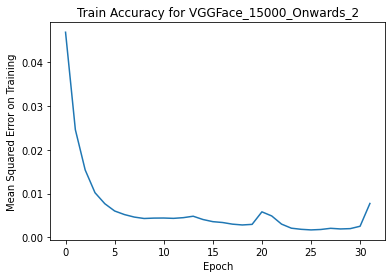

time: 271 ms (started: 2021-02-08 09:36:57 +00:00)


In [27]:
# simple_acc = H.history['mean_squared_error']

simple_acc = db['mean_squared_error']
plt.plot([acc for acc in simple_acc])
plt.title('Train Accuracy for '+ model_name)
plt.ylabel('Mean Squared Error on Training')
plt.xlabel('Epoch')
plt.savefig(save_path+'/Train_Acc.png')
plt.show()

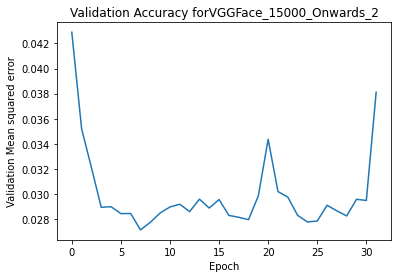

time: 274 ms (started: 2021-02-08 09:37:21 +00:00)


In [28]:
# simple_val_acc = H.history['val_mean_squared_error']
simple_val_acc = db['val_mean_squared_error']
plt.plot([acc for acc in simple_val_acc])
plt.title('Validation Accuracy for'+ model_name)
plt.ylabel('Validation Mean squared error')
plt.xlabel('Epoch')
plt.savefig(save_path+'/Validation_Acc.png')
plt.show()

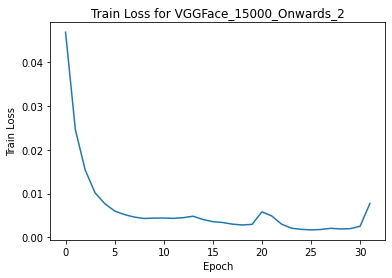

time: 227 ms (started: 2021-02-08 09:37:35 +00:00)


In [29]:
# simple_loss = H.history['loss']
simple_loss = db['loss']
plt.plot([los for los in simple_loss])
plt.title('Train Loss for '+ model_name)
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.savefig(save_path+'/Train_loss.png')
plt.show()

In [ ]:
simple_val_loss = H.history['val_loss']
plt.plot([los for los in simple_val_loss])
plt.title('Validation Loss for '+ model_name)
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.savefig(save_path+'/Validation_Loss.png')
plt.show()

Loss/Error Graphs

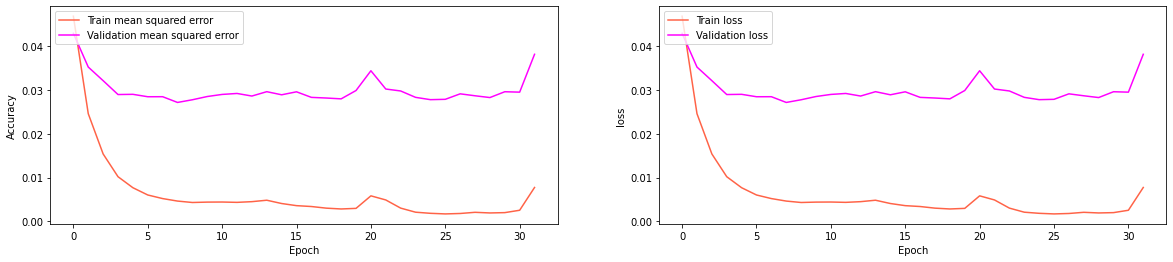

time: 491 ms (started: 2021-02-08 09:37:55 +00:00)


In [30]:
fig, axis = plt.subplots(1, 2, figsize=(20, 4))


axis[0].plot(db['mean_squared_error'],
         label='Train mean squared error',
         c='tomato', ls='-')
axis[0].plot(db['val_mean_squared_error'],
         label='Validation mean squared error',
         c='magenta', ls='-')

axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Accuracy')
axis[0].legend(loc='upper left')


axis[1].plot(db['loss'],
         label='Train loss',
         c='tomato', ls='-')
axis[1].plot(db['val_loss'],
         label='Validation loss',
         c='magenta', ls='-')

axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('loss')
axis[1].legend(loc='upper left')
plt.savefig(save_path+'/simple_Validation_error&loss.png')
plt.show()

# Testing

On the fly load

In [18]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

Testingdf = pd.read_csv("/content/drive/MyDrive/CV/cv project/CV-Project/Aff-Wild/Testing.csv")
testing = Testingdf.tail(5000)
test_datagen = ImageDataGenerator(rescale=1. / 255)

time: 143 ms (started: 2021-02-08 22:33:11 +00:00)


In [20]:
test_generator = test_datagen.flow_from_dataframe(
    testing,
    directory=None,
    x_col="Image_Path",
    y_col=["Valence","Arousal"],
    target_size=(img_width, img_height),
    color_mode="rgb",
    shuffle = False,
    class_mode="raw"
)

Found 5000 validated image filenames.
time: 1.81 s (started: 2021-02-08 22:46:17 +00:00)


Testing Model

In [34]:
score = model.evaluate(test_generator, batch_size=batch_size)

157/157 [==============================] - 2385s 15s/step - loss: 0.1381 - mean_squared_error: 0.1381
time: 40min 1s (started: 2021-02-08 09:47:38 +00:00)


In [35]:
import pickle
with open(save_path+'/score', 'wb') as file_pi:
        pickle.dump(score, file_pi)

time: 10.8 ms (started: 2021-02-08 10:27:40 +00:00)


In [37]:
print('Test Mean Squared Error = ', score[0])
print('Test Accuracy = ', score[1])

Test Mean Squared Error =  0.14309529960155487
Test Accuracy =  0.14309529960155487
time: 5.43 ms (started: 2021-02-08 10:27:40 +00:00)


In [21]:
# GET Concordance Correlation Coefficient
prediction = model.predict(test_generator)

time: 38min 59s (started: 2021-02-08 22:46:38 +00:00)


In [22]:
with open(save_path+'/predictions', 'wb') as file_pi:
        pickle.dump(prediction, file_pi)

time: 7.3 ms (started: 2021-02-08 23:25:37 +00:00)


In [10]:
import pickle
dbfile = open(save_path+'/predictions', 'rb')      
prediction = pickle.load(dbfile) 

time: 350 ms (started: 2021-02-08 22:23:47 +00:00)


In [48]:
sample = 96
prediction_v = prediction[sample,0]
prediction_a = prediction[sample,1]
print(prediction_v, prediction_a)

0.23642828 0.22228101
time: 2.3 ms (started: 2021-02-08 23:46:05 +00:00)


In [41]:
if prediction_v >= -0.5 and prediction_v <= 0.5 and prediction_a <= -0.66:
    print("focus")
elif prediction_v >= -0.2 and prediction_a >= -0.66 and prediction_a <= 0:
    print("relaxation")
elif prediction_v <= 0 and prediction_a <= 0:
    print("stress")
elif prediction_v >= 0 and prediction_v <= 0.4 and prediction_a >= 0 and prediction_a <= 0.4:
    print("interest")
elif (prediction_v >= 0 and prediction_v <= 0.7 and prediction_a >= 0.4 and prediction_a <= 0.7 or
      prediction_v >= 0.4 and prediction_v <= 0.7 and prediction_a >= 0 and prediction_a <= 0.4 or
      prediction_v >= 0.7 and prediction_v <= 1 and prediction_a >= 0 and prediction_a <= 1):
    print("engagement")
elif prediction_v >= 0 and prediction_v <= 1 and prediction_a >= 0.7 and prediction_a <= 1:
    print("excitement")
else:
    print("Cannot determine emotion")

interest
time: 6.96 ms (started: 2021-02-08 23:43:55 +00:00)


In [47]:
label_v = test_generator.labels[sample,0]
label_a = test_generator.labels[sample,1]
print(label_v, label_a)

0.0 0.196
time: 1.34 ms (started: 2021-02-08 23:45:51 +00:00)


In [46]:
if label_v >= -0.5 and label_v <= 0.5 and label_a <= -0.66:
    print("focus")
elif label_v >= -0.2 and label_a >= -0.66 and label_a <= 0:
    print("relaxation")
elif label_v <= 0 and label_a <= 0:
    print("stress")
elif label_v >= 0 and label_v <= 0.4 and label_a >= 0 and label_a <= 0.4:
    print("interest")
elif (label_v >= 0 and label_v <= 0.7 and label_a >= 0.4 and label_a <= 0.7 or
      label_v >= 0.4 and label_v <= 0.7 and label_a >= 0 and label_a <= 0.4 or
      label_v >= 0.7 and label_v <= 1 and label_a >= 0 and label_a <= 1):
    print("engagement")
elif label_v >= 0 and label_v <= 1 and label_a >= 0.7 and label_a <= 1:
    print("excitement")
else:
    print("Cannot determine emotion")

interest
time: 6.37 ms (started: 2021-02-08 23:45:25 +00:00)
